<a href="https://colab.research.google.com/github/alcrid/Anonymous-blog/blob/master/seq2seq_messenger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import re
import random
from keras.callbacks import ModelCheckpoint,CSVLogger
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.layers import Input, LSTM, Dense, Embedding, TimeDistributed
from keras.models import Model
from keras.utils.vis_utils import plot_model
import unidecode as uni



# Data preprocessing


In [ ]:
data = []
with open("drive/MyDrive/Data/sample.csv","r") as f:
  data = f.read()

In [ ]:
def remove_punctuation(s):
  return s.replace("!","").replace(".","").replace(",","").replace("?","")
dataset = []
for line in data.split("\n")[1:-1]:
  sentence = line.split(";")[:-1]
  dataset.append([remove_punctuation(sentence[0]),remove_punctuation(sentence[1])])
 

In [ ]:
text = []
encoder_input_data = []
decoder_input_data = []


for x in dataset:
    sent = ""
    max_words = 20
    for word in (x[0]).split(" "):
        if(word != ''):
          if(max_words == 0):
            break
          max_words -= 1
          sent += (word) + " "
    
    max_words = 20
    encoder_input_data.append(sent) 
    sent = ""
    for word in (x[1]).split(" "):
        if(word != ''):
            if(max_words == 0):
              break
            max_words -= 1
            sent += (word) + " "
    decoder_input_data.append(sent) 

print(encoder_input_data)
print(decoder_input_data)
def vocab_creater2(encoder_input_data,decoder_input_data):
       enword2idx = {}
       deword2idx = {}

       word2idx = {}
       deidx2word = {}
       i = 1
       enword2idx["<NOT>"] = 0
       for sent in encoder_input_data:
          for line in sent.split():
              if(not line in enword2idx and line != ""):
                   enword2idx[line] = i
                  
                   i += 1
       i = 1
       deword2idx["<NOT>"] = 0
       for sent in decoder_input_data:
         for line in sent.split():
              if(not line in deword2idx and line != ""):
                   deword2idx[line] = i
                   deidx2word[i] = line
                   i += 1

       return enword2idx,deword2idx,deidx2word
          


['ahoj ako sa mas ', 'serus ', 'cau ', 'serusco robis ', 'dobry den ', 'hello ', 'vitaj ', 'ahoj ', 'pozdravujem ', 'dobre rano ', 'dobry vecer ', 'greetings ', 'ahojte ako to ide ', 'vitaj ', 'dobry vecer ', 'ahoj ako sa mas ', 'serus ako to ide ', 'dobry den ', 'sup ', 'sup ', 'sup ', 'dobry den ', 'dobry den ', 'dobry den ', 'greetings ', 'pozdravujem ', 'serus jak zivot ', 'pozdravujem ', 'pozdravujem ', 'pozdravujem ', 'pozdravujem ', 'pozdravujem ', 'pozdravujem ', 'dobre rano ', 'dobre rano ', 'dobre rano ', 'dobre rano ', 'greetings fellow human ', 'greetings fellow human ', 'dovidenia ', 'dovidenia ', 'maj sa ', 'ok ja idem spat ', 'dovidenia ', 'dovidenia ', 'dovidenia ', 'dovidenia ', 'ja idem spat ', 'ja idem uz het serus ', 'idem het ', 'idem prec ', 'to je uz pre mna vsetko ja idem ', 'to je pre mna uz vsetko serus ', 'idem uz het ', 'to je vsetko ', 'idem het ', 'idem het ', 'maj sa ', 'dovidenia ', 'bye ', 'bye ', 'bozkavam ', 'bozkavam ', 'bozkavam ', 'bozkavam ', 'boz

In [ ]:
bos = "<SOS>"
eos = "<EOS>"
MAX_EN_LEN = 20
MAX_DE_LEN = 22
for i,sent in enumerate(decoder_input_data):
  tmp = ""
  for word in sent.split(" ")[::-1]:
    tmp += word + " "
  decoder_input_data[i] = tmp



for text in range(len(decoder_input_data)):
  decoder_input_data[text] = bos + decoder_input_data[text] + eos

enword2idx,deword2idx,deidx2word = vocab_creater2(encoder_input_data,decoder_input_data)
print(enword2idx)
print(deidx2word)

{'<NOT>': 0, 'ahoj': 1, 'ako': 2, 'sa': 3, 'mas': 4, 'serus': 5, 'cau': 6, 'serusco': 7, 'robis': 8, 'dobry': 9, 'den': 10, 'hello': 11, 'vitaj': 12, 'pozdravujem': 13, 'dobre': 14, 'rano': 15, 'vecer': 16, 'greetings': 17, 'ahojte': 18, 'to': 19, 'ide': 20, 'sup': 21, 'jak': 22, 'zivot': 23, 'fellow': 24, 'human': 25, 'dovidenia': 26, 'maj': 27, 'ok': 28, 'ja': 29, 'idem': 30, 'spat': 31, 'uz': 32, 'het': 33, 'prec': 34, 'je': 35, 'pre': 36, 'mna': 37, 'vsetko': 38, 'bye': 39, 'bozkavam': 40, 'za': 41, 'nevedel': 42, 'by': 43, 'si': 44, 'mi': 45, 'pomoct': 46, 'vysvetlis': 47, 'toto': 48, 'vysvetlit': 49, 'povedal': 50, 'co': 51, 'videl': 52, 'ten': 53, 'novy': 54, 'film': 55, 'vlastne': 56, 'oliver': 57, 'dnes': 58, 'nepride': 59, 'prides': 60, 'zajtra': 61, 'o': 62, 'pol': 63, 'budes': 64, 'moct': 65, 'hrat': 66, 'ty': 67, 'cooo': 68, 'fakt': 69, 'ahojtee': 70, 'acmko': 71, 'pripravilo': 72, 'takuto': 73, 'retaz': 74, 'bdenia': 75, 's': 76, 'jezisom': 77, 'kto': 78, 'chcete': 79, 'm

In [ ]:


encoder_input = np.zeros(
       (len(encoder_input_data), MAX_EN_LEN, len(enword2idx)),
       dtype='float32')

decoder_input = np.zeros(
       (len(decoder_input_data), MAX_DE_LEN+2, len(deword2idx)),
        dtype='float32')

decoder_target = np.zeros(
     (len(decoder_input_data), MAX_DE_LEN+2, len(deword2idx)), dtype='float32')


for line, (input_doc, target_doc) in enumerate(zip(encoder_input_data, decoder_input_data)):
    for word, token in enumerate(input_doc.split()):
        encoder_input[line, word, enword2idx[token]] = 1.
    
    for word, token in enumerate(target_doc.split()):
          decoder_input[line,word,deword2idx[token]] = 1.
          if word > 0:
              decoder_target[line,word - 1,deword2idx[token]] = 1.

print(encoder_input.shape)
print(decoder_input[68])

(1134, 20, 1985)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Model building




In [ ]:

EMBEDDING_DIM = 256
encoder_inputs = Input(shape=(None, len(enword2idx), ), name="Encoder_input")
encoder_LSTM = LSTM(EMBEDDING_DIM, return_state=True, name='Encoder_lstm')
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_inputs)
encoder_states = [state_h,state_c]


decoder_inputs = Input(shape=(None,len(deword2idx) ),name = "Decoder_input")
decoder_LSTM = LSTM(EMBEDDING_DIM, return_state=True, return_sequences=True, name="Decoder_lstm")
decoder_outputs, _, _ = decoder_LSTM(decoder_inputs, initial_state= encoder_states)
decoder_dense = Dense(len(deword2idx), activation='softmax', name="Dense_layer") 
decoder_outputs = decoder_dense(decoder_outputs) 




# Training model

In [ ]:
filepath="drive/MyDrive/Data/training_progress2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
callbacks_list = [checkpoint]

csv_logger = CSVLogger("drive/MyDrive/Data/model_history_log.csv", append=True)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer= "rmsprop", loss='categorical_crossentropy', metrics=['acc'],sample_weight_mode='temporal')

model.load_weights("drive/MyDrive/Data/training_progress2.hdf5")

# model.fit([encoder_input, decoder_input], decoder_target,
#          batch_size=16,
#          epochs=500,
#          validation_split=0.20,
#          callbacks=[callbacks_list,csv_logger])

In [ ]:
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder_input (InputLayer)     [(None, None, 1985)  0           []                               
                                ]                                                                 
                                                                                                  
 Decoder_input (InputLayer)     [(None, None, 2891)  0           []                               
                                ]                                                                 
                                                                                                  
 Encoder_lstm (LSTM)            [(None, 256),        2295808     ['Encoder_input[0][0]']          
                                 (None, 256),                                               

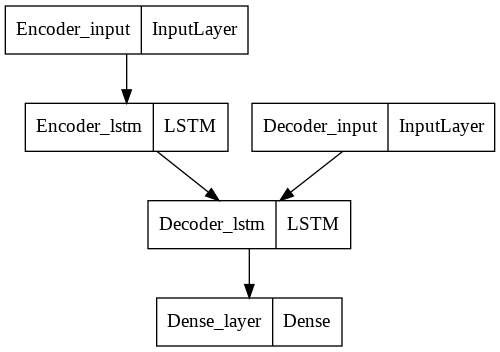

In [ ]:
plot_model(model)

# Interface model

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states) 

decoder_state_input_h = Input(shape=(EMBEDDING_DIM,), name="H_state_input") 
decoder_state_input_c = Input(shape=(EMBEDDING_DIM,), name="C_state_input") 
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c] 

decoder_outputs, state_h, state_c = decoder_LSTM(decoder_inputs,initial_state=decoder_states_inputs) 
decoder_states = [state_h, state_c] 
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [ ]:
decoder_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Decoder_input (InputLayer)     [(None, None, 2891)  0           []                               
                                ]                                                                 
                                                                                                  
 H_state_input (InputLayer)     [(None, 256)]        0           []                               
                                                                                                  
 C_state_input (InputLayer)     [(None, 256)]        0           []                               
                                                                                                  
 Decoder_lstm (LSTM)            [(None, None, 256),  3223552     ['Decoder_input[0][0]',    

# Chatbot response

In [ ]:
def process(sentence):
  sentence = re.sub("[?!,.1-9@#$%/\(){}+-=*&^>'\"]_~", "", sentence)
  sentence = uni.unidecode(sentence).lower().replace("  "," ")

  return sentence


def decode_response(test_input):
   
    input = ""
    for word in test_input.split()[::-1]:
      input += word + " "

    input_matrix = np.zeros((1, MAX_EN_LEN, len(enword2idx)),dtype='float32')
      
    for timestep, token in enumerate(input.split()):
      if token in enword2idx:
        input_matrix[0, timestep, enword2idx[token]] = 1.
      else:
        input_matrix[0, timestep, enword2idx["<NOT>"]] = 1.
      

    states_value = encoder_model.predict(input_matrix)

    target_seq = np.zeros((1, 1, len(deword2idx)))

    target_seq[0, 0, deword2idx['<SOS>']] = 1.
    
    decoded_sentence = '' 
    stop_condition = False
    while not stop_condition:

      output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
      
     
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      #print(sampled_token_index)
      sampled_token = deidx2word[sampled_token_index]

      if (sampled_token == '<EOS>' or len(decoded_sentence) > 22):
        stop_condition = True
      else:
        decoded_sentence += " " + sampled_token
      target_seq = np.zeros((1, 1, len(deword2idx)))
      target_seq[0, 0, sampled_token_index] = 1.


      states_value = [hidden_state, cell_state]
    
    out = ""
    for word in decoded_sentence.split()[::-1]:
      out += word + " "
    
    return out

print("write exit to stop")
while True:
  query = process(input())

  stopwords = ["stop","koniec","exit","dost"]
  if query in stopwords:
      break
  print(decode_response(query))

write exit to stop
dneska ako sa mas 
just it it je it sounded 
triggered co si das ze 
